<a href="https://colab.research.google.com/github/Vahe0795/Machine-Learning/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

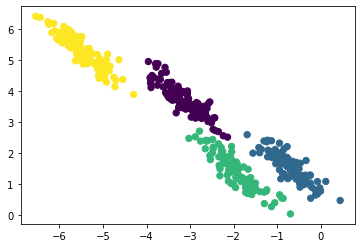

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting
rng = np.random.RandomState(13) # Random number Generator with fixed state
X_stretched = np.dot(X, rng.randn(2, 2))
X = X_stretched
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=40)

In [2]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal as mvn

class GMM:
    
    def __init__(self, k, max_iter=100, tol=1e-6):
        self.k = k 
        self.max_iter = max_iter
        self.tol = tol
    
    def init_centers(self, X):       
        kmeans = KMeans(n_clusters=self.k)
        kmeans_fit = kmeans.fit(X)
        prediction = kmeans.predict(X)
        mean_arr, cov_arr, pi_arr = self.calculate_mean_covariance(X, prediction)
        return mean_arr, cov_arr, pi_arr
        
    def calculate_mean_covariance(self, X, prediction):
        d = X.shape[1]
        labels = np.unique(prediction)
        mean_arr, cov_arr, pi_arr = np.zeros((self.k, d)), np.zeros((self.k, d, d)), np.zeros(self.k)
        index = 0
        for label in labels:
            ids = np.where(prediction == label)
            pi_arr[index] = len(ids[0]) / X.shape[0]
            mean_arr[index, :] = np.mean(X[ids], axis=0)
            de_meaned = X[ids] - mean_arr[index, :]
            Nk = X[ids].shape[0]
            cov_arr[index, :, :] = np.dot(pi_arr[index] * de_meaned.T, de_meaned) / Nk
            index += 1
        return mean_arr, cov_arr, pi_arr

    def fit(self, X):
        d = X.shape[1]
        mean_arr, cov_arr, pi_arr = self.calculate_mean_covariance(X, self.predict(X))
        for run in range(self.max_iter):
            gamma_mtrx = self.expectation(X, mean_arr, cov_arr, pi_arr)
            mean_arr, cov_arr, pi_arr = self.maximization(X, gamma_mtrx)
        return self

    def loss(self, X, mean_arr, cov_arr, pi_arr):
        N = X.shape[0]
        C = self.expectation(X, mean_arr, cov_arr, pi_arr).shape[1]
        self.loss = np.zeros(N, C)
        for c in range(C):
            dist = mvn(mean_arr[c], cov_arr[c], allow_singular=True)
            self.loss[:, c] = self.expectation(X, mean_arr, cov_arr, pi_arr)[:, c] * (
                    np.log(pi_arr[c] + self.tol) + dist.logpdf(X) -
                    np.log(self.expectation(X, mean_arr, cov_arr, pi_arr)[:, c] + self.tol))
        return np.sum(self.loss)
    
    def pdf(self, x, mean, cov):
        return (1/np.sqrt((2*np.pi)**(X.shape[1])*cov))*np.exp(-0.5*np.matmul((x-mean).T, np.matmul(cov, (x-mean))))
            
    def expectation(self, X, mean_arr, cov_arr, pi_arr):
        gamma_mtrx = np.zeros((X.shape[0], self.k))
        mean_arr, cov_arr, pi_arr = self.calculate_mean_covariance(X, self.predict(X))
        for c in range(self.k):
            gamma_mtrx[:, c] = pi_arr[c] * mvn.pdf(X, mean_arr[c, :], cov_arr[c])
        return gamma_mtrx

    def maximization(self, X, gamma_mtrx):
        Nk = gamma_mtrx.sum(axis=0)
        Z = gamma_mtrx.shape[1]
        self.mean_arr = np.dot(gamma_mtrx.T, X) / np.sum(gamma_mtrx, axis=0)[:, np.newaxis]
        self.pi_arr = np.mean(gamma_mtrx, axis=0)
        self.cov_arr = np.zeros((self.k, X.shape[1], X.shape[1]))
        for z in range(Z):
            x = X - self.mean_arr[z, :]
            gamma_diag = np.diag(gamma_mtrx[:, z])
            x_mu = np.matrix(x)
            gamma_diag = np.matrix(gamma_diag)
            sigma_c = x.T * gamma_diag * x
            self.cov_arr[z, :, :] = sigma_c / np.sum(gamma_mtrx, axis=0)[:, np.newaxis][z]
        return self.mean_arr, self.cov_arr, self.pi_arr 
        
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)
    
    def predict_proba(self, X):
        mean_arr, cov_arr, pi_arr = self.init_centers(X)
        post_proba = np.zeros((X.shape[0], self.k))
        for c in range(self.k):
            post_proba[:, c] = pi_arr[c] * mvn.pdf(X, mean_arr[c, :], cov_arr[c])
        denominator = post_proba.sum(axis=1)[:, np.newaxis]
        weights = post_proba / denominator
        return weights

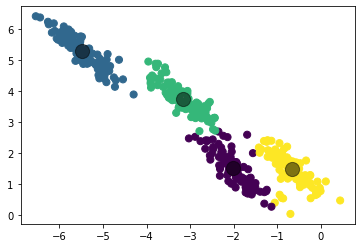

In [3]:
gmm = GMM(k=4)
gmm.fit(X)
pred = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred, s=50)
plt.scatter(gmm.mean_arr[:, 0], gmm.mean_arr[:, 1], c='black', s=200, alpha=0.5)

In [4]:
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
(gmm.predict_proba(X))

array([[0.0000, 0.3098, 0.0000, 0.6902],
       [0.0000, 0.0000, 1.0000, 0.0000],
       [0.0000, 0.0000, 1.0000, 0.0000],
       ...,
       [1.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 1.0000, 0.0000],
       [1.0000, 0.0000, 0.0000, 0.0000]])

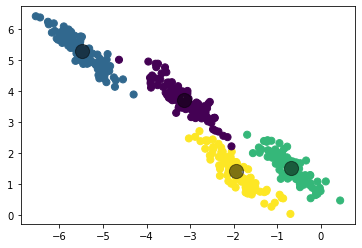

In [5]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=4)
gm.fit(X)
prediction = gm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=prediction, s=50, cmap='viridis')
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], c='black', s=200, alpha=0.5)

In [6]:
from scipy.stats import mode
from sklearn.metrics import confusion_matrix

permutation = np.array([
    mode(y_true[gmm.predict(X) == i]).mode.item() 
    for i in range(gmm.k)])
permuted_prediction = permutation[gmm.predict(X)]
print(np.mean(y_true == permuted_prediction))
confusion_matrix(y_true, permuted_prediction)

0.9725


array([[ 97,   0,   3,   0],
       [  0,  98,   2,   0],
       [  1,   5,  94,   0],
       [  0,   0,   0, 100]])